# Digit Sequence Recognition
---

In [1]:
'''
    Import packages and modules from Python Standard library and Third Party libraries!
    
'''
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Import from python standard library
import os
from datetime import timedelta
import time

# Import third party packages and modules 
import h5py
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0,4.0)

print('Tensorflow Version:',tf.__version__)

Tensorflow Version: 1.15.0


## Loading the data

Let's load the greyscale images created in preprocessing step.

In [2]:
# Open the HDF5 file containing the datasets
h5f = h5py.File('./data/2010_data__grey.h5', 'r')

# Extract the datasets fromm HDF5 object
X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
#X_test  = h5f['test_dataset'][:300]
#y_test  = h5f['test_labels'][:300]

# Close the file
h5f.close()

print('1. X_train Shape: Shape: {}'.format(X_train.shape, y_train.shape))
#print('2. X_test Shape: {} , y_test Shape: {}'.format(X_test.shape, y_test.shape))

1. X_train Shape: Shape: (14005, 112, 112, 1)


In [3]:
# Open the HDF5 file containing the datasets
h5f = h5py.File('./data/2010_overlap_test_grey.h5', 'r')

# Extract the datasets fromm HDF5 object
X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
X_test  = h5f['test_dataset'][:]
y_test  = h5f['test_labels'][:]

# Close the file
h5f.close()
print('2. X_test Shape: {} , y_test Shape: {}'.format(X_train.shape, y_train.shape))
print('1. X_test Shape: {} , y_test Shape: {}'.format(X_test.shape, y_test.shape))

2. X_test Shape: (1297, 112, 112, 1) , y_test Shape: (1297, 2)
1. X_test Shape: (3000, 112, 112, 1) , y_test Shape: (3000, 2)


Keep the data dimensions as they will be used multiple time in the following code

In [4]:
# Get data dimensions 
_, img_height, img_width, num_channels = X_train.shape

# Max lenth of digit sequence and total number of labels  
len_digitSeq, num_labels = y_train.shape[1], len(np.unique(y_train))

In [5]:
len_digitSeq, num_labels

(2, 10)

In [6]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
_, img_height, img_width, num_channels

(1297, 112, 112, 1)

Lets shuffle the training set using `sklearn.utils.shuffle`

In [8]:
# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test,y_test)
#X_test2, y_test2 = shuffle(X_test2,y_test2)

## Data Preprocessing

Mean subtraction is the most common form of preprocessing/normalization performed on image data before training a convolutional neural network. It centers the dataset around the origion along each dimension. The main reason of mean subtraction normalization that it normalizes the data around origion and helps in learning fast by controlling the gradient values range after multiplying with the learning rate in backpropagation process. Another way we can think that deep learning networks traditionally share the parameters but if the inputs not are scaled, the resulting feature values would not be in similar-range. Then sharing wolud not be easy becasue one part of image weight would be large and other would be small.    

There are two types of Mean subtraction normalization: 1.`Subtracting the mean of every image from that image`: It is a natural way of normalizing the image because the an image taken in day-light should be normalized with different mean than a night-time image.  2.`Sutracting the mean of whole dataset per channel`: If the lighning of image is controlled the both the techniques porfomed the same. 

We will use `subtracting mean of every image` for our dataset. 

In [9]:
def subtract_mean(dataset):
    '''
        Helper function for subtracting mean of every image
    '''
    for i in range(dataset.shape[0]):
        dataset[i]= dataset[i]-dataset[i].mean()
        
    return dataset

X_train = subtract_mean(X_train)
X_test = subtract_mean(X_test)
#X_test2 = subtract_mean(X_test2)

X_train.shape, X_test.shape
#, X_test2.shape

((1297, 112, 112, 1), (3000, 112, 112, 1))

## Helper functions
Let us implement helper functions to reuse the code 

### Helper function for plotting images

Here is a helper function that will help us plotting images and their true and predicted labels 

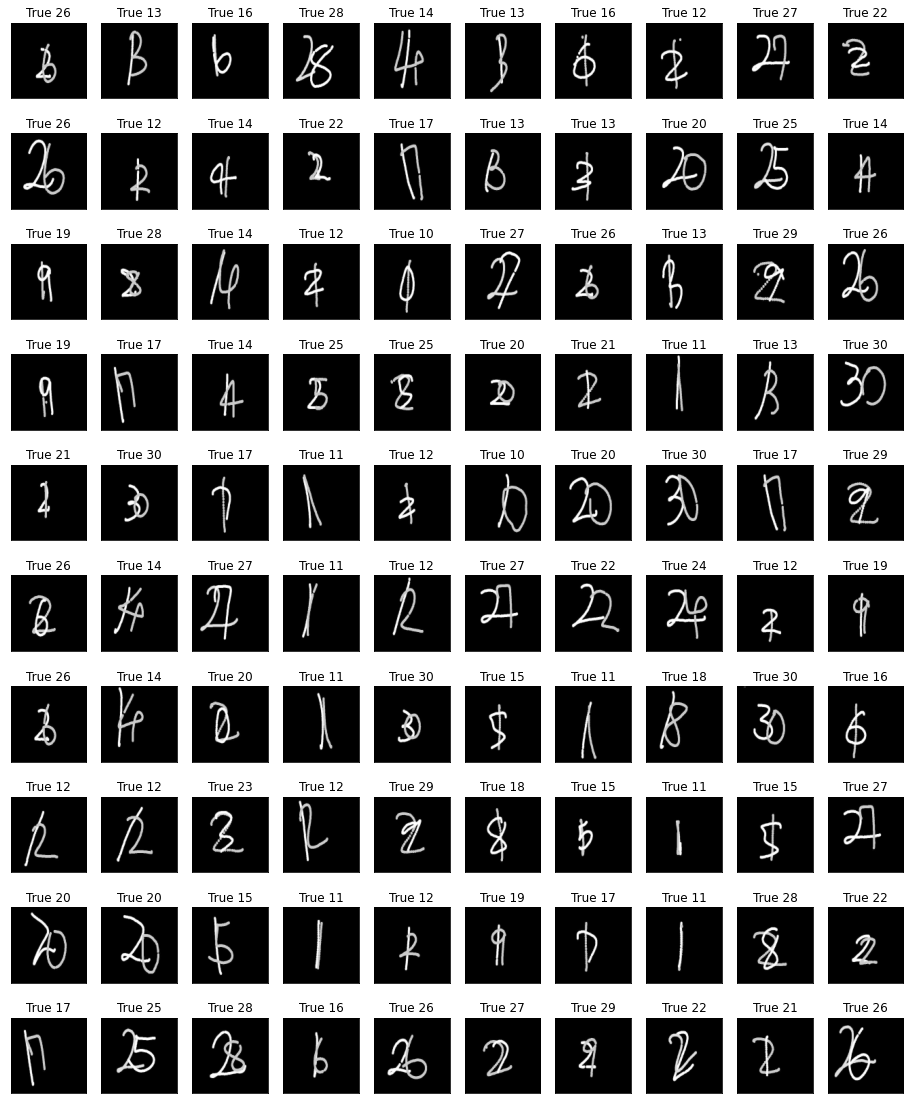

In [10]:
def plot_images(images, nrows, ncols, Cls_true, Cls_pred=None):
    
    '''
        Helper function to plot images
    '''
    
    fig, axes = plt.subplots(nrows,ncols, figsize=(16,2*nrows))
    
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    for i, ax in zip(rs, axes.flat):
        true_number = ''.join(str(x) for x in Cls_true[i] if x!=10)
        
        if Cls_pred is None:
            title = "True {0}".format(true_number)
            
        else:
            pred_number = ''.join(str(x) for x in Cls_pred[i] if x!=10)
            title = "Pred {0}".format(pred_number)
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)
        ax.set_xticks([]), ax.set_yticks([])
        
plot_images(X_train, 10,10, y_train)
plt.savefig('2010_train_data_non_overlap.jpg')

In [11]:
#plot_images(X_test,10,10, y_test)
#plt.savefig('2010_train_data_overlap.jpg')

### Helper functions for creating new variables 

Functions for creating `Tensorflow Variables` using the given shape and intializing them using the `Tensorflow Xavier_Initializer_conv2d`.

In [12]:
tf.reset_default_graph()
def init_conv_weights(shape, name):
    return tf.get_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def init_fc_weights(shape, name):
    return tf.get_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def init_biases(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

### Helper function for applying CONV-RELU layers followed by optional pooling layer 

In [13]:
def conv_layer(input_tensor, #the input or output of previoud layer
               filter_size, #width and height of each filter 
               in_channel,  #number of channels in previous layers or input
               num_filters, #number of filter (depth of filter) 
               layer_name, #Layer name
               pooling):  #2x2 max_pooling?
    
    '''
        Function for applying convolution to input_tensors
    '''
    
    with tf.name_scope(layer_name):
        
        #Shape of filter-weights
        shape = [filter_size, filter_size, in_channel, num_filters]
        
        #initialize weights and biases of conv-layer
        weights = init_conv_weights(shape=shape, name=layer_name+'/weights') 
        biases = init_biases([num_filters])
        
        #Add histogram summary for weights
        tf.summary.histogram(layer_name+'/weights', weights)
        
        #create tensorflow operation for convolution with stride=1 and zero padding
        activations = tf.nn.conv2d(input_tensor, weights, [1,1,1,1], 'SAME')+biases
        
        #apply rectified linear unit (Relu)
        activations = tf.nn.relu(activations)
        
        # Do we insert a pooling layer?
        if pooling:
            #create max pooling operation with F=2 and S=2 and zero padding
            activations = tf.nn.max_pool(activations, [1,2,2,1], [1,2,2,1],'SAME')
    
    return activations 

### Helper function for reshaping the CONV layers to FC layers 

In [14]:
def flatten_tensor(input_tensor):
    
    #get shape of input_tensor
    input_tensor_shape = input_tensor.get_shape()
    
    #get total number of elements in height, width and channel dimensions(excluding batch dimension) 
    num_activations = input_tensor_shape[1:4].num_elements()
    
    #Reshpe the input tensor into dimensions (batch,num_activations) 
    input_tensor_flat = tf.reshape(input_tensor, [-1, num_activations])
    
    return input_tensor_flat, num_activations

### Helper function for stacking FC-Relu layers

In [15]:
def fc_layer(input_tensor,
            input_dim,
            output_dim,
            layer_name,
            relu=False):
    
    with tf.name_scope(layer_name):
        #create weights anf biases
        weights = init_fc_weights(shape=[input_dim, output_dim], name=layer_name +'/weights')
        biases  = init_biases([output_dim])
        
        #create histogram of weihgts for tensorboard visualizations
        tf.summary.histogram(layer_name+'/weights', weights)
        
        #multiply input_tensor and weights to get activations 
        activations = tf.matmul(input_tensor, weights)+biases
        #apply Relu unit to activations if relu?
        if relu:
            activations = tf.nn.relu(activations)
    
    return activations  

### Tensorflow Model

In [16]:
#Block1
filter_size1 = filter_size2 = 5
num_filters1 = num_filters2  = 32

#Block2
filter_size3 =  filter_size4 = 5
num_filters3  =  num_filters4  = 64

#Block3
filter_size5 = filter_size6 = filter_size7 = 5
num_filters5 = num_filters6 = num_filters7 = 128

#fully connected layers
fc1_size = fc2_size = 256

### Creating Placeholders for input data and dropout  keep_prob

In [17]:
with tf.name_scope("input"):
    x  = tf.placeholder(tf.float32, shape=[None, img_height, img_width, num_channels], name='x')
    y_ = tf.placeholder(tf.int64, shape=[None,len_digitSeq], name='y_')

with tf.name_scope("dropout"):
    #Dropout rate applied to input layer
    p_keep_1 = tf.placeholder(tf.float32)
    tf.summary.scalar('input_keep_probability', p_keep_1)
    
    #Dropout rate applied after pooling layers 
    p_keep_2 = tf.placeholder(tf.float32)
    tf.summary.scalar('conv_keep_probability', p_keep_2)
    
    #Dropout rate applied between fully connected layers
    p_keep_3 = tf.placeholder(tf.float32)
    tf.summary.scalar('fc_keep_probability', p_keep_3)

### Create model by stacking layers 

In [18]:
def model():
    
    '''
        Helper function for defining the model by stacking Conv, Relu and pooling and FC laeyrs  
    '''
    #apply dropout to the input 
    drop_input = tf.nn.dropout(x, p_keep_1)
    print(drop_input.shape)
    
    #Block1
    conv_1 = conv_layer(input_tensor=drop_input, filter_size=filter_size1, in_channel=num_channels, num_filters=num_filters1, layer_name='conv_1', pooling=False)
    print(conv_1.shape)
    conv_2 = conv_layer(input_tensor=conv_1, filter_size=filter_size2, in_channel=num_filters1, num_filters=num_filters2, layer_name='conv_2', pooling=True)
    print(conv_2.shape)
    #apply dropout after pooling
    drop_block1 = tf.nn.dropout(conv_2, p_keep_2)
    
    #Block2
    conv_3 = conv_layer(input_tensor=conv_2, filter_size=filter_size3, in_channel=num_filters2, num_filters=num_filters3, layer_name='conv_3', pooling=False)
    print(conv_3.shape)
    conv_4 = conv_layer(input_tensor=conv_3, filter_size=filter_size4, in_channel=num_filters3, num_filters=num_filters4, layer_name='conv_4', pooling=True)
    #apply dropout after pooling
    print(conv_4.shape)
    drop_block2 = tf.nn.dropout(conv_4, p_keep_2)
    
    #Block3
    conv_5 = conv_layer(input_tensor=conv_4, filter_size=filter_size5, in_channel=num_filters4, num_filters=num_filters5, layer_name='conv_5', pooling=False)
    print(conv_5.shape)
    conv_6 = conv_layer(input_tensor=conv_5, filter_size=filter_size6, in_channel=num_filters5, num_filters=num_filters6, layer_name='conv_6', pooling=False)
    print(conv_6.shape)
    conv_7 = conv_layer(input_tensor=conv_6, filter_size=filter_size7, in_channel=num_filters6, num_filters=num_filters7, layer_name='conv_7', pooling=True)
    print(conv_7.shape)
    #apply dropout after pooling
    drop_block3 = tf.nn.dropout(conv_7, p_keep_3)
    
    #flatten the tensor
    flat_tensor, num_activations = flatten_tensor(drop_block3)
    print(flat_tensor.shape)
    
    #Fully connected layer1
    fc_1 = fc_layer(input_tensor=flat_tensor, input_dim=num_activations, output_dim=fc1_size, layer_name='fc_1', relu=True)
    print(fc_1.shape)
    drop_fc2 = tf.nn.dropout(fc_1, p_keep_3)
    
    #Fully connected layer2
    fc_2 = fc_layer(input_tensor=drop_fc2, input_dim=fc1_size, output_dim=fc2_size, layer_name='fc_2', relu=True)
    print(fc_2.shape)
    
    #parallel softmax layers
    logits_1 = fc_layer(input_tensor=fc_2, input_dim=fc2_size, output_dim=num_labels, layer_name='softmax1')
    logits_2 = fc_layer(input_tensor=fc_2, input_dim=fc2_size, output_dim=num_labels, layer_name='softmax2')
    print(logits_1.shape,logits_2.shape)
    
    y_pred = tf.stack([logits_1, logits_2])
    
    y_pred_cls = tf.transpose(tf.argmax(y_pred, axis=2))
    
    return logits_1, logits_2, y_pred_cls

In [19]:
#create model
logits_1, logits_2, y_pred_cls = model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 112, 112, 1)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(?, 112, 112, 32)
(?, 56, 56, 32)
(?, 56, 56, 64)
(?, 28, 28, 64)
(?, 28, 28, 128)
(?, 28, 28, 128)
(?, 14, 14, 128)
(?, 25088)
(?, 256)
(?, 256)
(?, 10) (?, 10)


### What are logits in ML? 

1. The logits are the vector of raw predictions that a classification model generates. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class.
2. For Tensorflow: It's a name that it is thought to imply that this Tensor is the quantity that is being mapped to probabilities by the Softmax.
3. The raw predictions which come out of the last layer of the neural network.
    * This is the very tensor on which you apply the argmax function to get the predicted class.
    * This is the very tensor which you feed into the softmax function to get the probabilities for the predicted classes.
    * If you are still confused, the situation is like this:
    
    `
    raw_predictions = neural_net(input_layer)
    predicted_class_index_by_raw = argmax(raw_predictions)
    probabilities = softmax(raw_predictions)
    predicted_class_index_by_prob = argmax(probabilities)`
    
    where, predicted_class_index_by_raw and predicted_class_index_by_prob will be equal.

 
4. For more detail: [stackoverflow ](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow) .



In [20]:
logits_1, logits_2, y_pred_cls

(<tf.Tensor 'softmax1/add:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'softmax2/add:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'transpose:0' shape=(?, 2) dtype=int64>)

### Loss Function

We will calculate the loss by taking the average loss of each individual example for each of the 2 digits. We will be using `tf.nn.sparse_softmax_cross_entropy_with_logits` which can allow us skip the oneHotEncoding on label values. 

Check out difference between `logits, tf.nn.softmax and tf.nn.sparse_softmax_cross_entropy_with_logits` at [stackoverflow  ](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits).

In [21]:
with tf.name_scope('loss'):
    #calculate loss for individual digits in the sequence
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_1, labels=y_[:,0]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_2, labels=y_[:,1]))
    
    #calculate total loss for all predictions 
    loss = loss1+loss2
    
    tf.summary.scalar('loss',loss)

### optimization method 

In [22]:
with tf.name_scope('optimizer'):
    
    #Global step is required to compute the decay of learning rate
    global_step = tf.Variable(0,trainable=False)
    
    #apply exponential decay to the learning rate 
    learning_rate = tf.train.exponential_decay(1e-4, global_step, 7500, 0.5, staircase=True)
    
    tf.summary.scalar('learning_rate',learning_rate)
    
    #apply RMSPropOptimizer to minimize the loss
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Evaluation Metric

In [23]:
with tf.name_scope('accuracy'):
    
    # Predicted classes equal the true class of each image?  
    # Cast prediction to float[[True, True]] and take min of [[1.0,1.0]] and also reduce the dims to [1.0,1.0]
    correct_prediction = tf.reduce_min(tf.cast(tf.equal(y_pred_cls,y_),tf.float32),1) 
    
    #calculate average of predictions and multiply by 100 to calculate accuracy
    accuracy = tf.reduce_mean(correct_prediction)*100
    
    tf.summary.scalar('accuracy', accuracy)

### Tensorflow Run

In [24]:
#launch the graph in session
session = tf.Session()

### Creat Saver Object to Save and Restore Tensorflow graph variables   

In [25]:
saver = tf.train.Saver()

save_path = os.path.join('C:/Users/rashi/Desktop/Elevator/multi-digit-leap-motion/checkpoints/','2010_model_v2')

try:
    print('Restoring Checkpoints .....')
    
    #restore checkpoint using restore function
    saver.restore(session, save_path)
    print('Restored checkpoint from:', save_path)
    
except:
    print('Failed to restore checkpoints - initializing variables')
    session.run(tf.global_variables_initializer())

Restoring Checkpoints .....
Failed to restore checkpoints - initializing variables


### Write Tensorboard summaries using `tf.summary.FileWriter`

In [26]:
LOG_DIR = '/logs/2010_model_v2'

#merge all summaries
merged = tf.summary.merge_all()

#pass graph to the Filewriter to disply it in tensorboard 
train_writer = tf.summary.FileWriter(LOG_DIR+'/train', session.graph)
validation_writer = tf.summary.FileWriter(LOG_DIR+'/validation', session.graph)

### Optimization

In [27]:
#If you run out of memory, switch to smaller batch size 
batch_size = 128

#dropout applied to input layer 
d1 = 0.9

#dropout applied to conv layers
d2 = 0.75

#dropout applied to FC layers
d3 = 0.6

In [28]:
def feed_dict(step=0):
    
    '''
        Helper fucntiont to generate mini batches of training data and return feed_dict to intput to tensorflow graph.
    '''
    
    #calcualte the offset for mini-batch
    offset = (step*batch_size)%(y_train.shape[0]-batch_size)
    
    #get the mini-batch
    xs, ys = X_train[offset:offset+batch_size], y_train[offset:offset+batch_size]
    
    #return feed_dict 
    return {x:xs, y_:ys, p_keep_1:d1, p_keep_2:d2, p_keep_3:d3}

def evaluate_batch(test, batch_size):
    
    #Store the cummulative accuracy over the all batches
    cumulative_accuracy = 0.0
    
    #Get the number of images 
    n_images = y_test.shape[0] if test else y_val.shape[0]
    
    #Get the number of batches
    n_batches = n_images//batch_size +1
    
    for i in range(n_batches):
        
        #get the offset
        offset = i*batch_size
       
        if test:
            #get the batch of test images 
            xs, ys = X_test[offset:offset+batch_size], y_test[offset:offset+batch_size]
            
        else:
            #get the batch of val images 
            xs, ys = X_val[offset:offset+batch_size], y_val[offset:offset+batch_size]
        
        cumulative_accuracy += session.run(accuracy, {x:xs, y_:ys, p_keep_1:1.0, p_keep_2:1.0, p_keep_3:1.0})
        
    #get average accuracy over batch
    return cumulative_accuracy/(0.0+n_batches)

In [29]:
def optimize(num_iterations, display_step):
    #start-time used for printing time-usage
    start_time = time.time()
    
    for step in range(num_iterations):
        
        #Run the optimizer using this batch of training data
        summary, i, _= session.run([merged, global_step, optimizer], feed_dict(step))
        train_writer.add_summary(summary,i)
        
        #print the status every display step iteration and last iteration
        if(i%display_step==0) or (step==num_iterations-1):
            
            #calculate mini-batch accuracy
            batch_acc = session.run(accuracy, feed_dict(step))
            print("Mini-batch accuracy at step %d: %.4f" %(i, batch_acc))
    
    # Total training time
    run_time = time.time() - start_time
    print("\nTime usage: " + str(timedelta(seconds=int(round(run_time)))))
    
    # Calculate and display the testset accuracy
    test_acc = evaluate_batch(test=True, batch_size=512)
    print("Test accuracy: %.4f" % test_acc)
    
    # Save all the variables of the TensorFlow graph
    saver.save(session, save_path=save_path, global_step=global_step)
    print('Model saved in file: {}'.format(save_path))

In [30]:
optimize(num_iterations=2000, display_step=200)

Mini-batch accuracy at step 200: 81.2500
Mini-batch accuracy at step 400: 94.5312
Mini-batch accuracy at step 600: 100.0000
Mini-batch accuracy at step 800: 99.2188
Mini-batch accuracy at step 1000: 100.0000
Mini-batch accuracy at step 1200: 100.0000
Mini-batch accuracy at step 1400: 100.0000
Mini-batch accuracy at step 1600: 100.0000
Mini-batch accuracy at step 1800: 99.2188
Mini-batch accuracy at step 2000: 100.0000

Time usage: 0:09:22
Test accuracy: 90.6226
Model saved in file: C:/Users/rashi/Desktop/Elevator/multi-digit-leap-motion/checkpoints/2010_model_v2


In [ ]:
def predict(image, label=None):
    image = cv2.resize(np.float32(image), dsize=(
        112, 112), interpolation=cv2.INTER_AREA)
    image = np.expand_dims(
        np.dot(image, [0.2989, 0.5870, 0.1140]), axis=3).astype(np.float32)
    img = np.expand_dims(image, axis=0)
    
    return pred

In [ ]:
import cv2

image_path = "C:/Users/rashi/Desktop/Elevator/testcases/17.jpg"
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
test =image = cv2.resize(image,dsize=(112,112), interpolation= cv2.INTER_AREA)
image = image-image.mean()
image = np.expand_dims(np.dot(image, [0.2989, 0.5870, 0.1140]), axis=2).astype(np.float32)
image = np.expand_dims(image, axis=0)
plt.imshow(test, cmap='binary')

In [ ]:
image.shape

In [ ]:
pred = session.run(y_pred_cls, feed_dict={
                       x: image, p_keep_1: 1., p_keep_2: 1., p_keep_3: 1.})

In [ ]:
pred

### Test Performance 



In [31]:
def get_predictions(batch_size,Xt,yt):
    
    #Store the cummulative accuracy over the all batches
    test_predictions= []
    
    #Get the number of images 
    n_images = yt.shape[0]
    
    #Get the number of batches
    n_batches = n_images//batch_size +1
    
    for i in range(n_batches):
        
        #get the offset
        offset = i*batch_size
       
        #get the batch of test images 
        xs, ys = Xt[offset:offset+batch_size], y_test[offset:offset+batch_size]
        #get predictions on mini-batch
        test_pred = session.run(y_pred_cls, {x:xs, y_:ys, p_keep_1:1.0, p_keep_2:1.0, p_keep_3:1.0})
        #save prediction in test_predictions list
        test_predictions.append(test_pred)
        
    #get average accuracy over batch
    return test_predictions

In [32]:
#get list of predictions for each batch
test_predictions = get_predictions(batch_size=128, Xt=X_test, yt=y_test)
test_pred = test_predictions[0]
#extract prediction of each batch and vstack them 
for indx in range(1,len(test_predictions)):
        test_pred = np.vstack([test_pred, test_predictions[indx]])

### Individual digit accuracy
Lets calculate classifier accuracy on each individual digit

In [33]:
from sklearn.metrics import accuracy_score

#find the positions of non-zero digits
non_zero = np.where(y_test.flatten()!=10)

#calculate the accuracy on individula digit level
accuracy_score(test_pred.flatten()[non_zero], y_test.flatten()[non_zero])

0.9498333333333333

### Calculate confusion matrix and plot it
Plot confusion matrix to check performance of classifier on each individual class

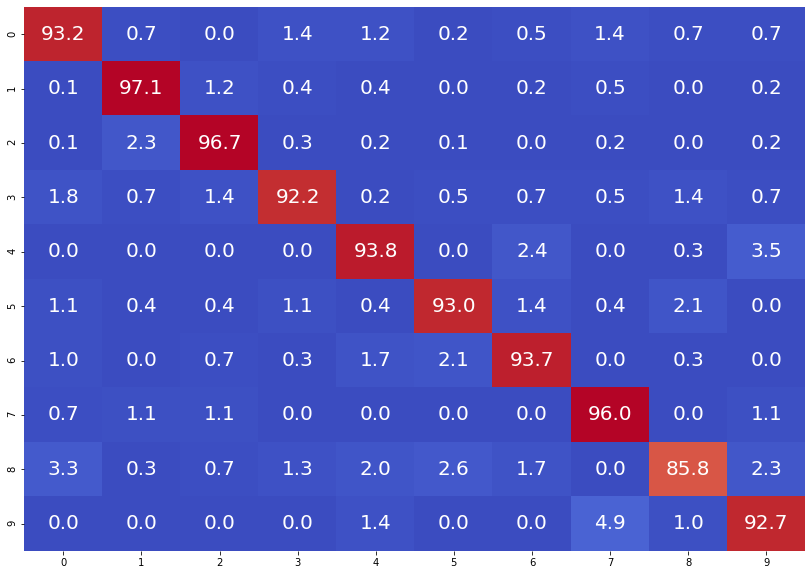

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#set the size of figure 
plt.figure(figsize=(14,10))

#calculate the confusion metrics
cm = confusion_matrix(y_test.flatten()[non_zero], test_pred.flatten()[non_zero])
#Normalize the confusion matrix 
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]*100
cm = cm[:10,:10]
#plot confusion matrix
p=sns.heatmap(cm, xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9],cbar=False, annot=True, cmap='coolwarm',robust=True, fmt='.1f',annot_kws={'size':20})

#savefig
#plt.savefig('confusion_matrix_non_overlapped-7.jpg')


### Digit Sequence lengths impact on performace 
Let us check how our model is able to predict the labels for correctly for different sequence lengths 


In [35]:
def calculate_accuracy(a,b):
    '''
        Calculate % of similar row in both numpy array: a and b
    '''
    correct = np.sum(np.all(a==b, axis=1))
    
    return 100*(correct/(0.0+a.shape[0]))

for num_digits in range(1,3):
    
    #find all the images index which have digit sequence lenght equals to num_digits
    images = np.where((y_test!=10).sum(1)==num_digits)
    
    #calculate accuracy
    acc = calculate_accuracy(test_pred[images], y_test[images])
    print('{:d} digit accuracy {:.3f}'.format(num_digits, acc))

1 digit accuracy nan
2 digit accuracy 90.567


C:\Users\rashi\anaconda3\envs\flow_14\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


### Plot correctly classified images 
Lets plot some correctly classfied test images and plot them with ture and predicted labels

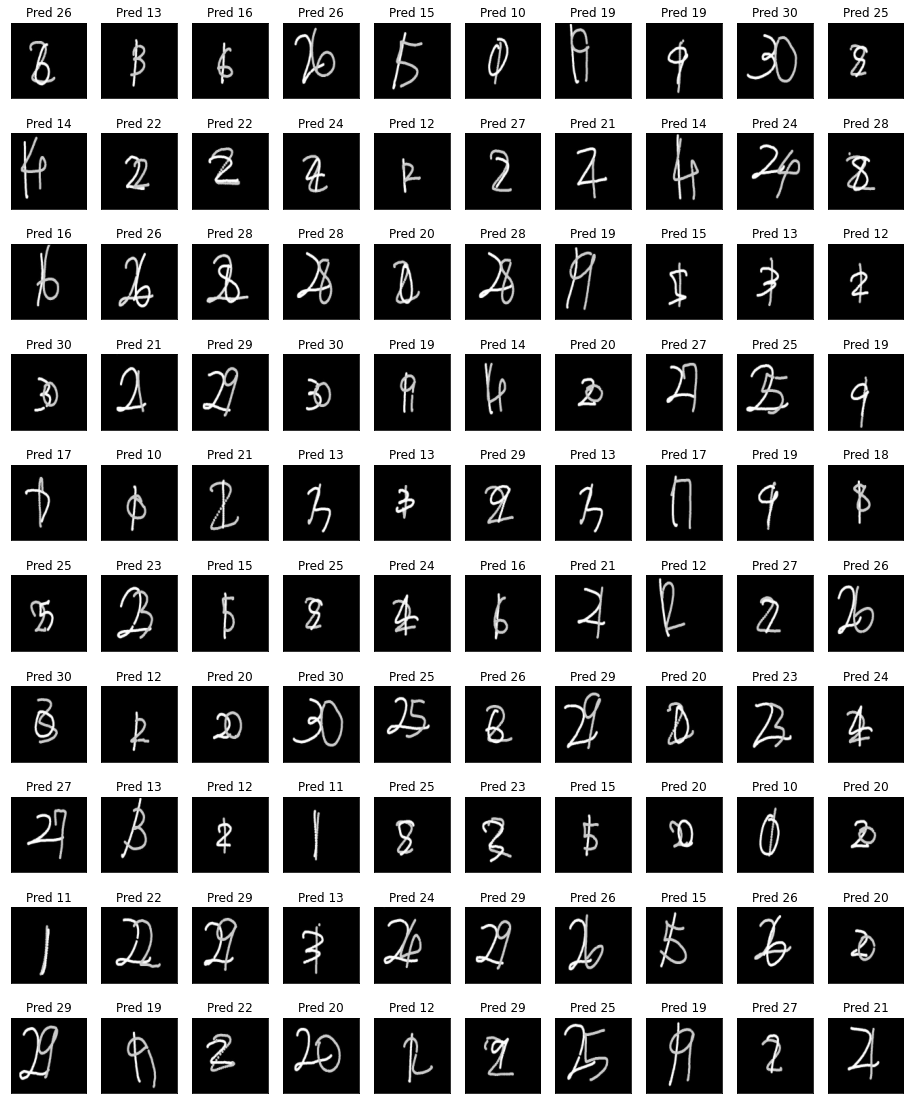

In [40]:
correct = np.array([np.all(a==b) for a, b in zip(y_test, test_pred)])

images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

plot_images(images, 10, 10, cls_true, cls_pred)
#plt.savefig('correctly_classified_non_overlapped-7.jpg')

In [41]:
len(images)

2717

### Plot incorrectly classified images 
Lets invert the boolean array and plot some incorrectly classified images

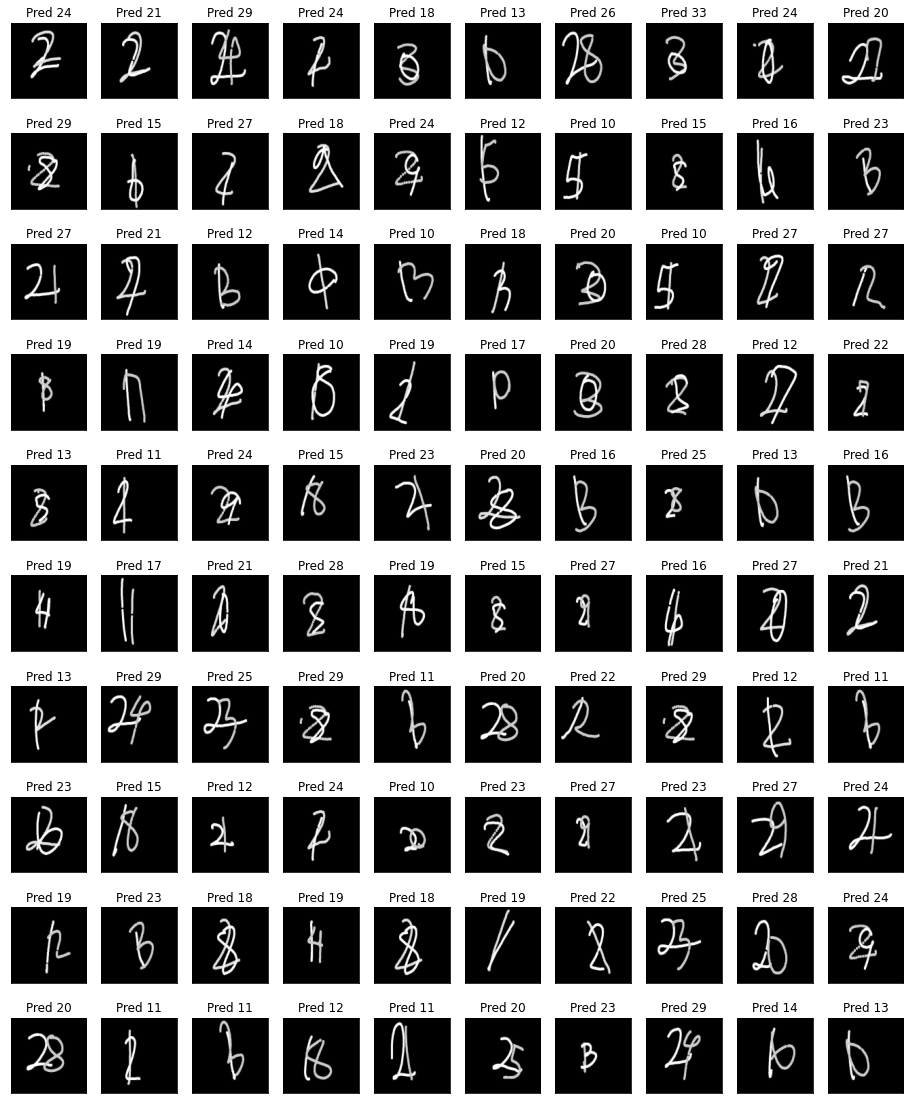

In [37]:
images = X_test[~correct]
cls_true = y_test[~correct]
cls_pred = test_pred[~correct]

plot_images(images, 10, 10, cls_true, cls_pred)
#plt.savefig('incorrectly_classified_non_overlapped-7.jpg')

In [38]:
len(images)

283